In [24]:
import jax.numpy as np
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Conv, Dense, Flatten, Relu, Softmax
from jax.experimental import optimizers
from jax import jit, grad
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torchvision import datasets, transforms

import numpy as onp
from tqdm import tqdm
import itertools
from functools import partial
import time

In [25]:
def one_hot(labels, num_classes, dtype=np.float32):
  return np.array(labels[:, None] == np.arange(num_classes), dtype)

def mnist_simple_cnn(num_classes):
  init_fun, conv_net = stax.serial(Conv(out_chan=32, filter_shape=(5, 5), strides=(2, 2), padding="SAME"),
                                   BatchNorm(), Relu,
                                   Conv(out_chan=32, filter_shape=(5, 5), strides=(2, 2), padding="SAME"),
                                   BatchNorm(), Relu,
                                   Conv(out_chan=10, filter_shape=(3, 3), strides=(2, 2), padding="SAME"),
                                   BatchNorm(), Relu,
                                   Conv(out_chan=10, filter_shape=(3, 3), strides=(2, 2), padding="SAME"), 
                                   BatchNorm(), Relu,
                                   Flatten,
                                   Dense(num_classes),
                                   Softmax)
  return init_fun, conv_net

In [26]:
class CNNclassifier:
  # Initialize the class
  def __init__(self, num_classes, rng_key):
    # Store number of classes
    self.num_classes = num_classes

    # Use stax to set up network initialization and evaluation functions
    self.net_init, self.net_apply = mnist_simple_cnn(self.num_classes)
    
    # Initialize parameters, not committing to a batch shape
    _, self.net_params = self.net_init(rng_key, (-1, 1, 28, 28))
                
    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                    decay_steps=100, 
                                                                    decay_rate=0.99))
    self.opt_state = self.opt_init(self.net_params)

    # Logger
    self.itercount = itertools.count()
    self.log_acc_train = []
    self.log_acc_test = [] 
    self.train_loss = []
    
  # Define a simple mean squared-error loss
  def loss(self, params, batch):
      inputs, targets = batch
      predictions = self.net_apply(params, inputs)
      loss = -np.sum(targets*np.log(predictions + 1e-8))
      return loss
    
  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def accuracy(self, params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs = np.array(inputs)
        targets = one_hot(np.array(targets), self.num_classes)
        target_labels = np.argmax(targets, axis=1)
        predicted_labels = np.argmax(self.net_apply(params, inputs), axis=1)
        acc_total += np.sum(predicted_labels == target_labels)
    return acc_total/len(data_loader.dataset)
  
  # Optimize parameters in a loop
  def train(self, train_loader, test_loader, num_epochs = 1000):
    for epoch in range(num_epochs):
      start_time = time.time()
      # Run epoch
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          batch = np.array(inputs), one_hot(np.array(targets), self.num_classes)
          self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      epoch_time = time.time() - start_time
      # Compute training and validation accuracy
      self.net_params = self.get_params(self.opt_state)  
      loss = self.loss(self.net_params, batch)
      train_acc = self.accuracy(self.net_params, train_loader)
      test_acc = self.accuracy(self.net_params, test_loader)
      self.train_loss.append(loss)
      self.log_acc_train.append(train_acc)
      self.log_acc_test.append(test_acc)
      print("Epoch {} | Time: {:0.2f} | Train Acc.: {:0.3f}% | Test Acc.: {:0.3f}%".format(epoch+1, epoch_time,
                                                                  train_acc, test_acc)) 

In [27]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [28]:
num_classes = 10
init_key = random.PRNGKey(0)
model = CNNclassifier(num_classes, init_key)

In [29]:
model.train(train_loader, test_loader, num_epochs = 10)

Epoch 1 | Time: 19.42 | Train Acc.: 0.970% | Test Acc.: 0.967%
Epoch 2 | Time: 14.45 | Train Acc.: 0.980% | Test Acc.: 0.974%
Epoch 3 | Time: 14.32 | Train Acc.: 0.986% | Test Acc.: 0.981%
Epoch 4 | Time: 14.14 | Train Acc.: 0.988% | Test Acc.: 0.981%
Epoch 5 | Time: 14.91 | Train Acc.: 0.991% | Test Acc.: 0.983%
Epoch 6 | Time: 14.15 | Train Acc.: 0.989% | Test Acc.: 0.980%
Epoch 7 | Time: 14.17 | Train Acc.: 0.993% | Test Acc.: 0.984%
Epoch 8 | Time: 14.88 | Train Acc.: 0.994% | Test Acc.: 0.982%
Epoch 9 | Time: 13.86 | Train Acc.: 0.995% | Test Acc.: 0.985%
Epoch 10 | Time: 14.14 | Train Acc.: 0.995% | Test Acc.: 0.982%


In [ ]:
plt.figure()
plt.sublot(1,2,1)
plt.plot(model.train_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.sublot(1,2,2)
plt.plot(model.log_acc_train, label = 'Training')
plt.plot(model.log_acc_test, label = 'Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

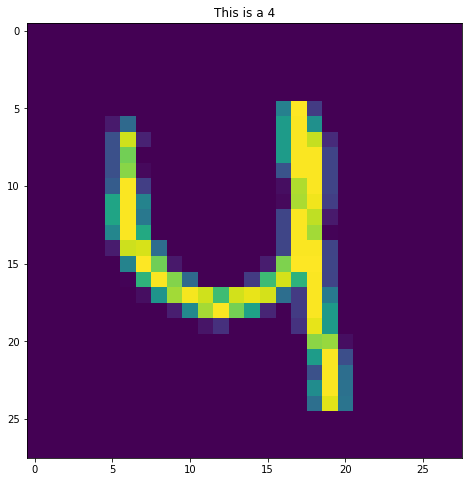

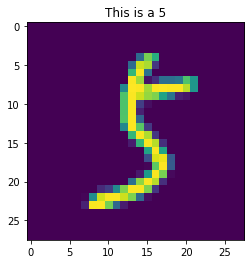

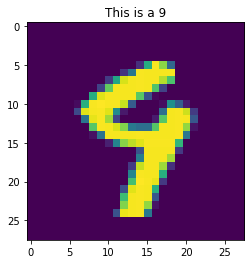

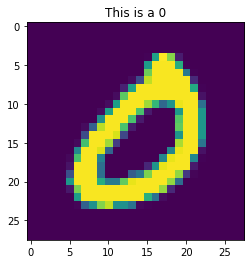

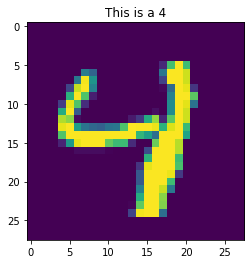

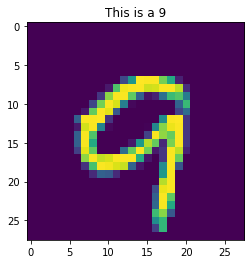

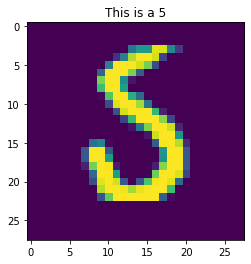

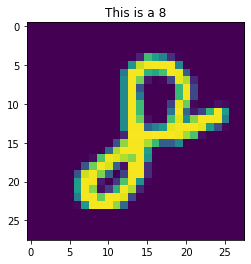

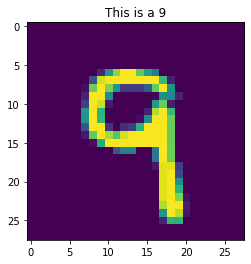

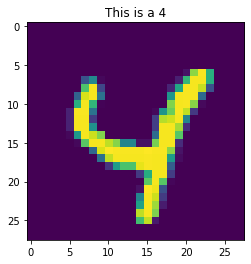

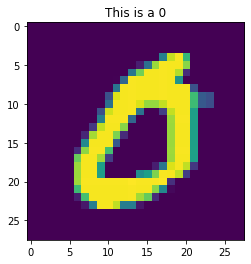

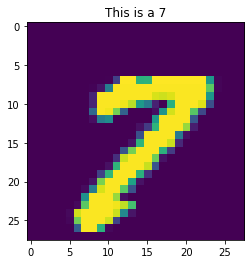

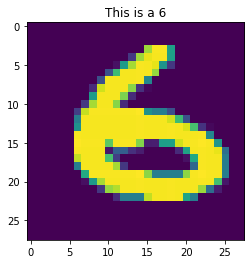

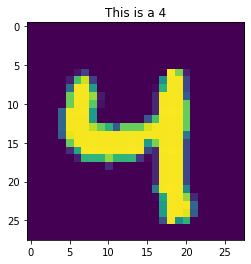

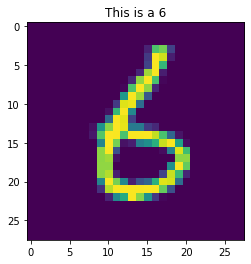

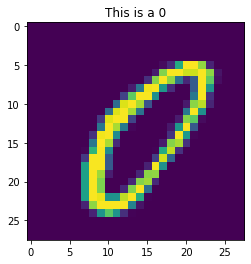

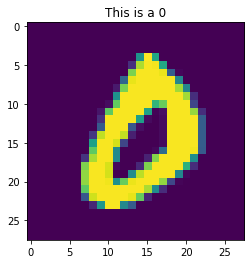

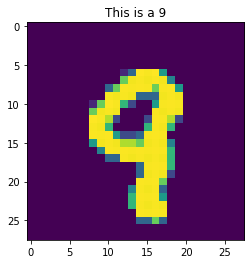

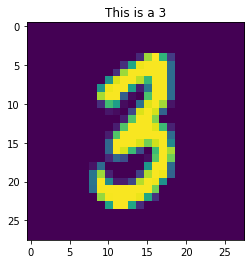

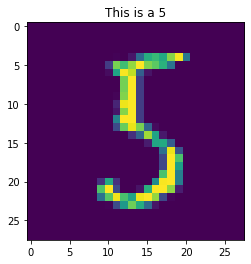

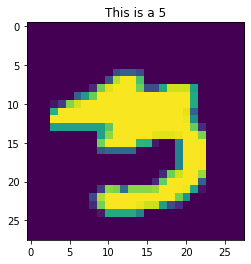

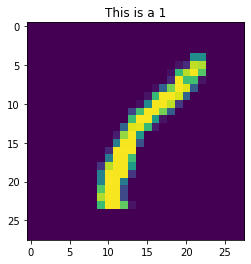

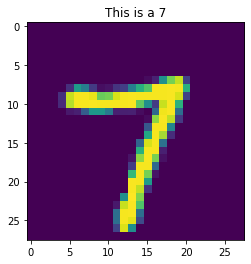

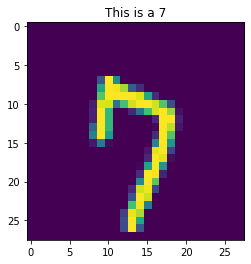

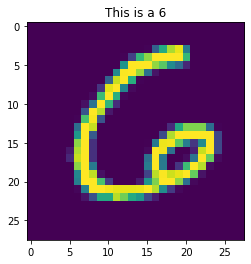

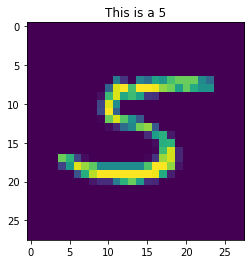

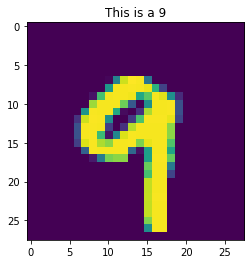

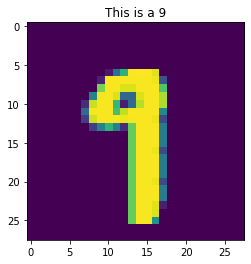

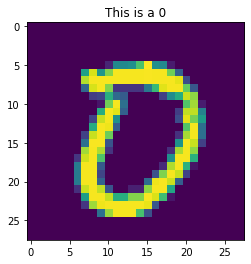

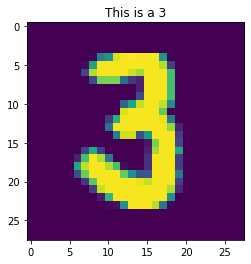

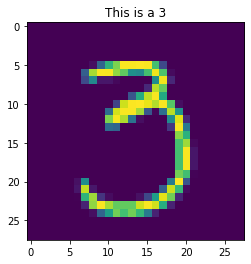

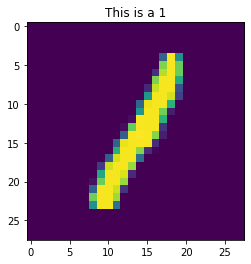

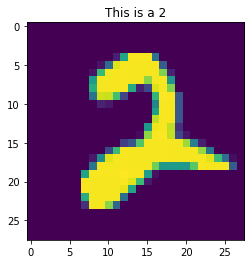

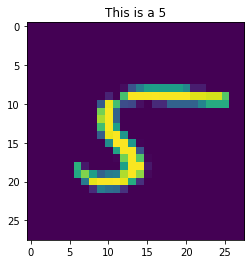

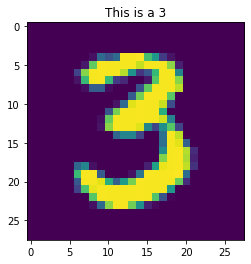

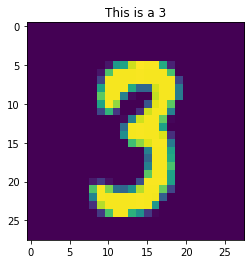

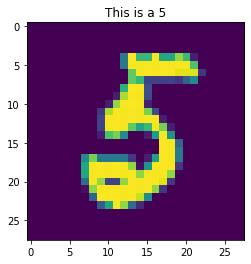

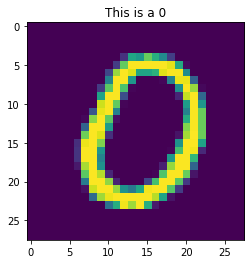

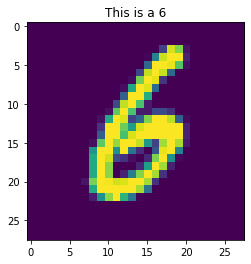

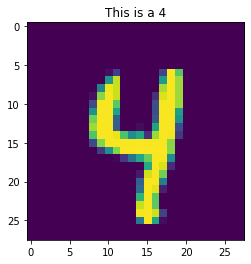

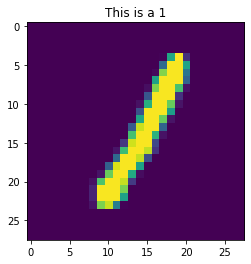

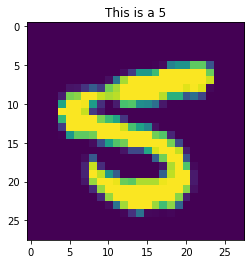

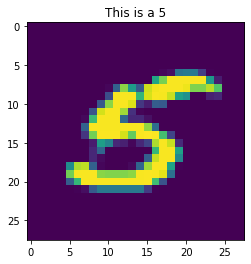

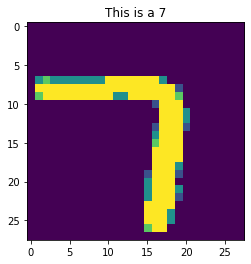

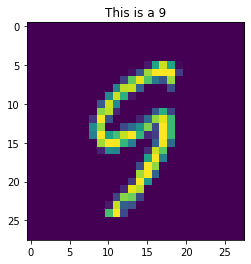

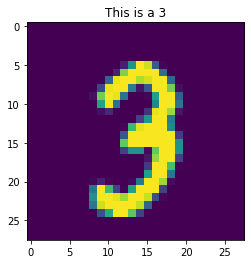

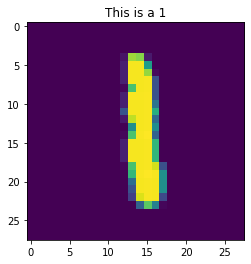

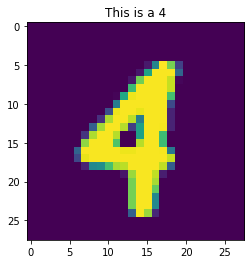

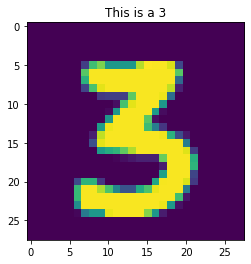

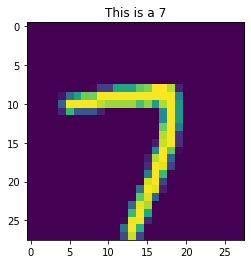

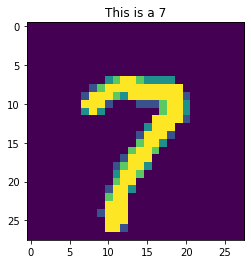

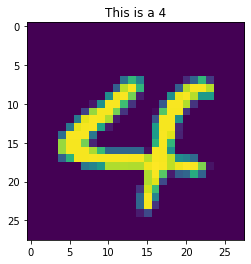

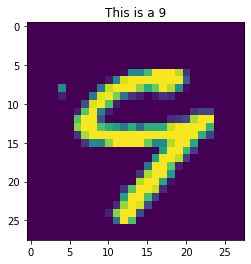

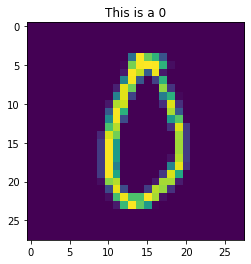

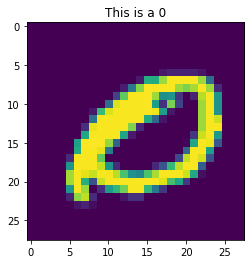

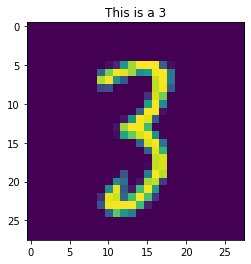

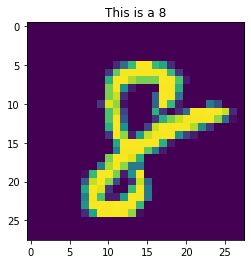

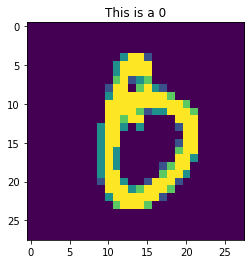

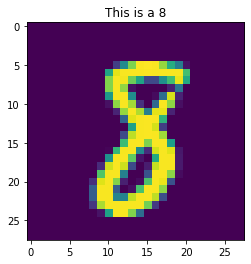

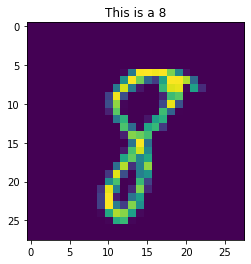

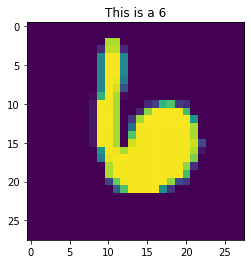

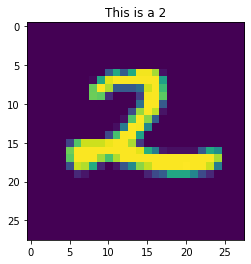

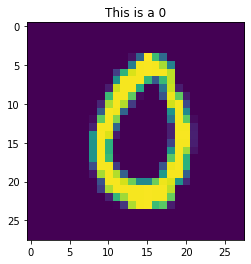

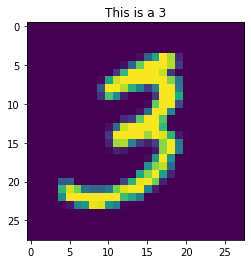

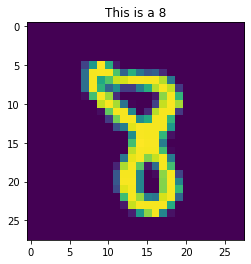

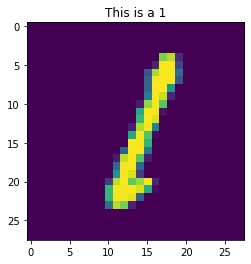

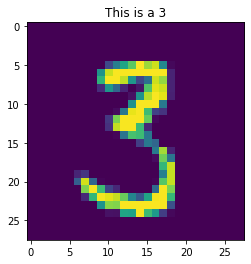

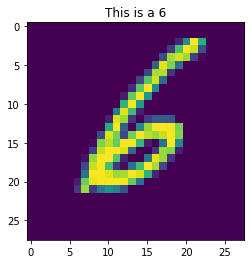

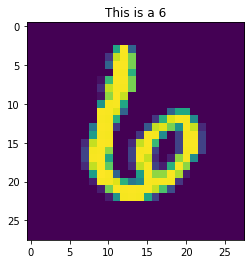

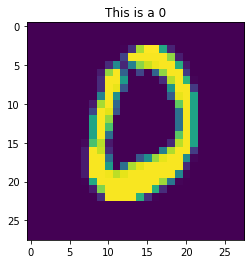

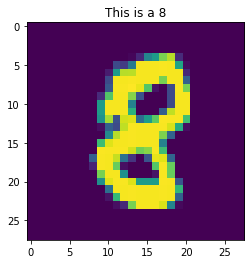

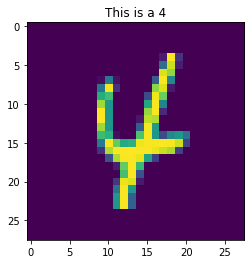

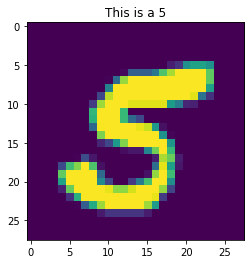

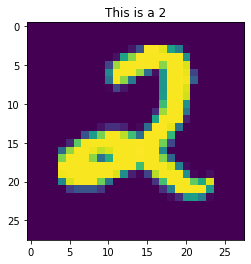

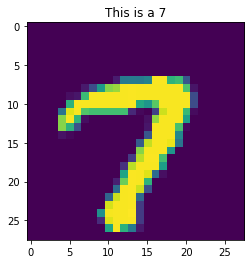

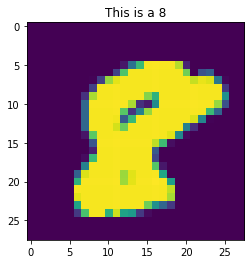

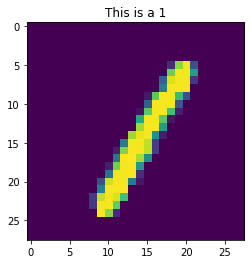

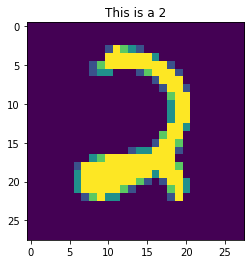

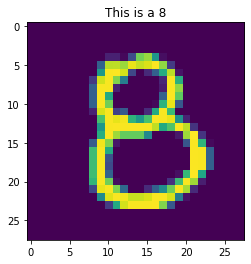

In [30]:
# Visualize some predictions
plt.figure(figsize = (8,8))
for batch_idx, (image, label) in enumerate(test_loader): 
  # Perform predictions
  opt_params = model.net_params
  predicted_labels = np.argmax(model.net_apply(opt_params, np.array(image)), axis=-1)
  plt.imshow(image[-1].reshape(28,28))
  plt.title('This is a %d' % (predicted_labels[-1]))
  plt.pause(0.5)